# Brain Tumor Classification Model

I will use this note book to investigate the dataset and train and test a machine learning model.

## Data

The data comes from kaggle ([data](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)) which I have dowloaded straight to a data folder in this repo but will not be included.

I'm going to start with some data exploration.

In [19]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

dataset_dir = 'data'

# Exploration
image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_files.append(os.path.join(root, file))
num_images = len(image_files)
print(f"Total number of images: {num_images}")


Total number of images: 3264


### Visualisation

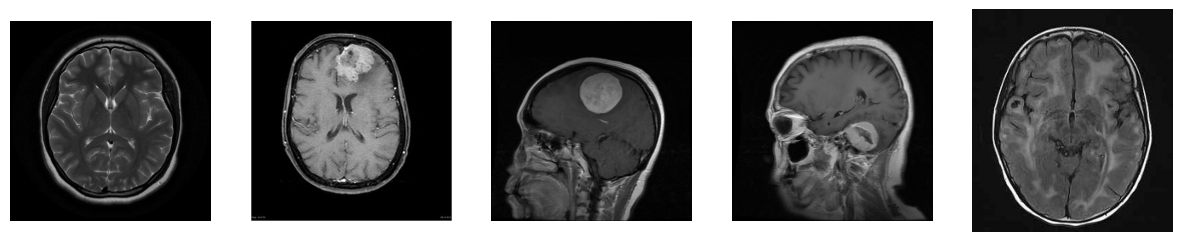

In [20]:
# Visualization
random.seed(10)  # Set a seed for reproducibility
sample_images = random.sample(image_files, 5)  # Select 5 random images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, image_path in enumerate(sample_images):
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()

So far I can see I have a fairly large dataset of pretty detailed images.

### General Statistics

Now I want to know the sizes of the images.

In [21]:
# Image Statistics
image_shapes = []
for image_path in image_files:
    image = cv2.imread(image_path)
    image_shapes.append(image.shape)
image_shapes = np.array(image_shapes)
print(f"Image dimensions (width, height, colour channels):\n Mean: {np.mean(image_shapes, axis=0)}\n Min: {np.min(image_shapes, axis=0)}\n Max: {np.max(image_shapes, axis=0)}")

Image dimensions (width, height, colour channels):
 Mean: [469.78094363 467.11856618   3.        ]
 Min: [167 174   3]
 Max: [1446 1375    3]


All the shapes are pretty similar which is convenient. Also note that there is 3 colour channels so the images are all RGB.

### Class Distribution

Next I want to see how the images are distributed between the possible classifications.

In [22]:
# Class Distribution
class_counts = {}
for image_path in image_files:
    class_name = os.path.basename(os.path.dirname(image_path))  # Directory represents the class
    if class_name in class_counts:
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 1
print(f"Class distribution: {class_counts}")

Class distribution: {'glioma_tumor': 926, 'meningioma_tumor': 937, 'no_tumor': 500, 'pituitary_tumor': 901}


This is a slightly uneven split and the no_tumor class is underepresented. For now I will continue without adjustment but depending on model accuracy this may need reassessment but I will use an evaluation metric that will try to minimise this issue.

### Class Examples

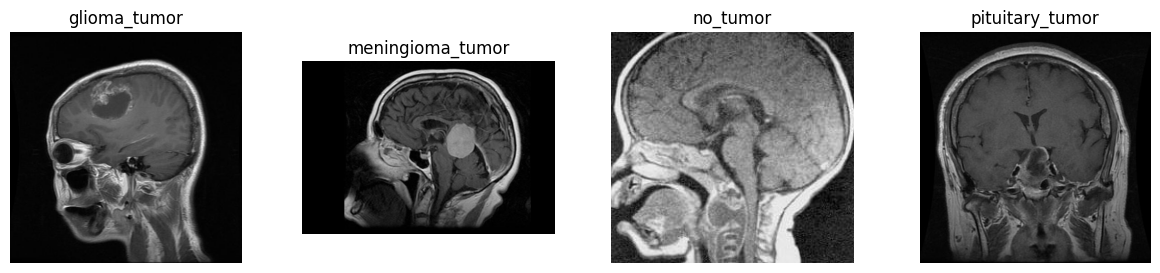

In [25]:
class_examples = {}
random.seed(8)
for class_name in class_counts.keys():
    class_images = [image_path for image_path in image_files if os.path.basename(os.path.dirname(image_path)) == class_name]
    class_examples[class_name] = random.choice(class_images)
fig, axes = plt.subplots(1, len(class_examples), figsize=(15, 3))
for i, (class_name, image_path) in enumerate(class_examples.items()):
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(class_name)
    axes[i].axis('off')
plt.show()

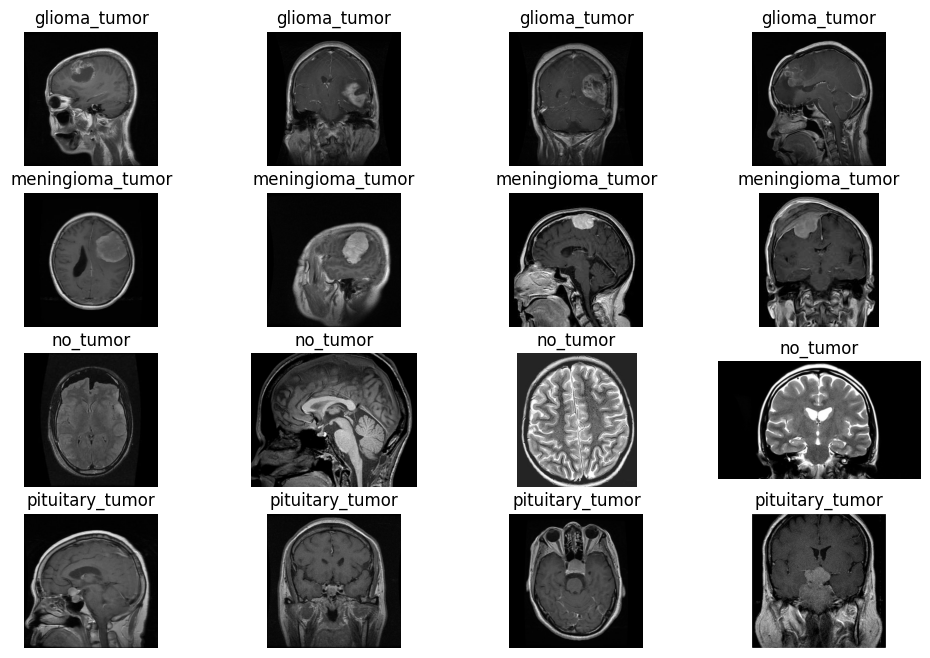

In [26]:
# Sampled Mini-Batch
random.seed(8)
classes_to_visualize = list(class_counts.keys())
num_samples_per_class = 4
fig, axes = plt.subplots(len(classes_to_visualize), num_samples_per_class, figsize=(12, 8))
for i, class_name in enumerate(classes_to_visualize):
    class_images = [image_path for image_path in image_files if os.path.basename(os.path.dirname(image_path)) == class_name]
    sampled_images = random.sample(class_images, num_samples_per_class)
    for j, image_path in enumerate(sampled_images):
        image = plt.imread(image_path)
        axes[i][j].imshow(image)
        axes[i][j].axis('off')
        axes[i][j].set_title(class_name)
plt.show()

The images for each class are very varied and are different views of the the head. This will be a very challenging problem for the model to be able to classify the images.

However, even with no medical training there does appear to be some patterns that can be seen manually in the batches so it will be interesting to see if the model is able to pick up a pattern.

## Preprocessing

I'm going to use the Tensorflow library to preprocess the data (and create the model).

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing and Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize
    shear_range=0.2,    # Randomly apply shearing transformations
    zoom_range=0.2,     # Randomly apply zoom transformations
    horizontal_flip=True  # Randomly flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'data\Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data\Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
for layer in vgg16.layers:
    layer.trainable = False

# Add classification layers
model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
model.fit(train_generator, epochs=10)

# Step 7: Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/10
90/90 [==============================] - 12s 129ms/step - loss: 1.2446 - accuracy: 0.5693
Epoch 2/10
90/90 [==============================] - 12s 130ms/step - loss: 0.7295 - accuracy: 0.7007
Epoch 3/10
90/90 [==============================] - 12s 130ms/step - loss: 0.6326 - accuracy: 0.7369
Epoch 4/10
90/90 [==============================] - 12s 130ms/step - loss: 0.5994 - accuracy: 0.7610
Epoch 5/10
90/90 [==============================] - 12s 130ms/step - loss: 0.5509 - accuracy: 0.7732
Epoch 6/10
90/90 [==============================] - 12s 130ms/step - loss: 0.5201 - accuracy: 0.7930
Epoch 7/10
90/90 [==============================] - 12s 130ms/step - loss: 0.4870 - accuracy: 0.8045
Epoch 8/10
90/90 [==============================] - 12s 130ms/step - loss: 0.5306 - accuracy: 0.7878
Epoch 9/10
90/90 [==============================] - 12s 129ms/step - loss: 0.4515 - accuracy: 0.8188
Epoch 10

We can see that after the 10th epoc we were not gaining any accuracy so the number of epochs seemed good. The accuracy on the test was significantly lower than the training data so the model is likely overfitting so this will need to be addressed.

Additionally, this took nearly an hour to fit the model locally with CPU only so I will also enable the GPU going forward.

We are going to start with 3 techniques to reduce overfitting:

- More data augmentation
- Regularisation
- Early Stopping

In [1]:
import tensorflow as tf
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Add rotation augmentation
    width_shift_range=0.2,  # Add horizontal shift augmentation
    height_shift_range=0.2  # Add vertical shift augmentation
)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'data\Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data\Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
for layer in vgg16.layers:
    layer.trainable = False

# Dropout and Regularisation
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Add L2 regularization
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

tensorboard_callback = TensorBoard(log_dir='logs')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(train_generator, epochs=12, callbacks=[early_stopping, tensorboard_callback])

# Step 7: Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/12
90/90 [==============================] - 14s 140ms/step - loss: 2.9556 - accuracy: 0.4780
Epoch 2/12
90/90 [==============================] - 13s 138ms/step - loss: 1.4438 - accuracy: 0.5690
Epoch 3/12
90/90 [==============================] - 13s 138ms/step - loss: 1.2640 - accuracy: 0.5617
Epoch 4/12
90/90 [==============================] - 12s 138ms/step - loss: 1.2130 - accuracy: 0.5310
Epoch 5/12
90/90 [==============================] - 13s 139ms/step - loss: 1.1299 - accuracy: 0.5697
Epoch 6/12
90/90 [==============================] - 12s 137ms/step - loss: 1.1220 - accuracy: 0.5760
Epoch 7/12
90/90 [==============================] - 12s 138ms/step - loss: 1.1340 - accuracy: 0.5589
Epoch 8/12
90/90 [==============================] - 12s 138ms/step - loss: 1.1326 - accuracy: 0.5634
Epoch 9/12
90/90 [==============================] - 13s 139ms/step - loss: 1.1532 - accuracy: 0.5362
Epoch 10

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Add rotation augmentation
    width_shift_range=0.2,  # Add horizontal shift augmentation
    height_shift_range=0.2  # Add vertical shift augmentation
)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'data\Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data\Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
for layer in vgg16.layers:
    layer.trainable = False

# # Dropout and Regularisation
# from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dense(256),  # Add L2 regularization
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

tensorboard_callback = TensorBoard(log_dir='logs')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(train_generator, epochs=12, callbacks=[early_stopping, tensorboard_callback])

# Step 7: Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/12
90/90 [==============================] - 36s 381ms/step - loss: 1.4132 - accuracy: 0.3321
Epoch 2/12
90/90 [==============================] - 36s 395ms/step - loss: 1.2411 - accuracy: 0.4408
Epoch 3/12
90/90 [==============================] - 40s 448ms/step - loss: 1.1570 - accuracy: 0.4976
Epoch 4/12
90/90 [==============================] - 40s 446ms/step - loss: 1.1118 - accuracy: 0.5286
Epoch 5/12
90/90 [==============================] - 35s 390ms/step - loss: 1.0630 - accuracy: 0.5449
Epoch 6/12
90/90 [==============================] - 35s 382ms/step - loss: 1.0321 - accuracy: 0.5808
Epoch 7/12
90/90 [==============================] - 34s 378ms/step - loss: 1.0146 - accuracy: 0.5868
Epoch 8/12
90/90 [==============================] - 34s 379ms/step - loss: 0.9819 - accuracy: 0.6003
Epoch 9/12
90/90 [==============================] - 34s 378ms/step - loss: 0.9817 - accuracy: 0.6073
Epoch 10

Lets add split some validation data from the training data.

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import numpy as np
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Adding validation so need to seperate the training data
image_directory = 'data\Training'

image_arrays = []
labels = []

target_size = (224, 224)

# Iterate through each subdirectory (class) in the image directory
for class_name in os.listdir(image_directory):
    class_path = os.path.join(image_directory, class_name)

    if not os.path.isdir(class_path):
        continue
    
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        
        image_arrays.append(img)
        labels.append(class_name)

# Convert lists to numpy arrays
image_arrays = np.array(image_arrays)
categories = {
    'glioma_tumor': 0,
    'no_tumor': 1,
    'meningioma_tumor' : 2,
    'pituitary_tumor': 3
}
labels = [categories[x] for x in labels]
labels = np.array(labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    image_arrays,
    labels,
    test_size=0.2,
    random_state=42
)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)

X_train, y_train = shuffle(X_train,y_train, random_state=8)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Add rotation augmentation
    width_shift_range=0.2,  # Add horizontal shift augmentation
    height_shift_range=0.2  # Add vertical shift augmentation
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

batch_size = 32

print(X_train.shape)
print(X_val.shape)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    'data\Testing',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)


effnet = EfficientNetB0(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers to prevent their weights from being updated during training
for layer in effnet.layers:
    layer.trainable = False

# # Dropout and Regularisation
# from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dense(256),  # Add L2 regularization
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
tensorboard_callback = TensorBoard(log_dir='logs')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)
model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks=[tensorboard_callback, checkpoint,reduce_lr]
)

# Step 7: Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

(2296, 224, 224, 3)
(574, 224, 224, 3)
Found 394 images belonging to 4 classes.
Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 1.3911 - accuracy: 0.2893
Epoch 1: val_accuracy improved from -inf to 0.31618, saving model to effnet.h5


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.